In [191]:
!pip install tensorflow
!pip install keras scikit_learn

# **Sales and Volume Forecasting Model**

## **Sales and Quantity Forecasting model overvie**


*   The  model uses online Retail Data from UC Irvine Machine Learning Repository
Online Retail - UCI Machine Learning Repository
*  Link to the data source https://archive.ics.uci.edu/dataset/352/online+retail

*   This data set contains all 541909 transactions between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online global retail company.
*   In this model we used RNN (Recurrent Neural Network) to develop forecasting sales dollars and sales quantities
*   We used hyperparamter tuning to find the optimal RNN models that produced the forecast with the least RMSE
*   The model takes around 30 minutes to run, primarily to search for optimal parameters for RNN




The following cell consists of all the imported libraries for this model

In [192]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

filterwarnings('ignore')



**Setting the random seed**

In [193]:
np.random.seed(42)
tf.random.set_seed(42)

## **Loading the data**

**This cell of the code is only applicable if you are using Colabs and Google Drive**

If you are not using Google Drive to load the data then comment the code in this cell.
If you are using Goolge Drive to load the data then "update" the drive location to the folder name where you have the data saved



In [194]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SalesForecastingProject

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SalesForecastingProject


**File path for the data file**

Please update the filepath for the OnlineRetail data file

In [195]:
filepath="data/OnlineRetail.xlsx"

**Loading and initial profiling of the data**

In [196]:

online_retail_data = pd.read_excel(filepath)
online_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [197]:
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## **Feature Engineering of data**


*   Convert the InvoiceDate timestamp to a datetime object
*   Create "FullDate" feature that only has the data
*   Create "Year" feature that only has the year for the Invoice
*   Create "Month" feature that only has the month for the Invoice
*   Create "YearMonth" feature that has the Year and Month for the Invoice
*   Create "DayOfWeek" feature that has the Day of the week for the Invoice
*   Create "SalesDollars" feature that is unit price of the item multiplied by the quantity










In [198]:
online_retail_data['InvoiceDate'] = pd.to_datetime(online_retail_data['InvoiceDate'])

In [199]:
online_retail_data['FullDate'] = online_retail_data['InvoiceDate'].dt.date
online_retail_data['Year'] = online_retail_data['InvoiceDate'].dt.year
online_retail_data['Month'] = online_retail_data['InvoiceDate'].dt.month
online_retail_data['YearMonth'] = online_retail_data['InvoiceDate'].dt.strftime('%Y-%m')
online_retail_data['DayOfWeek'] = online_retail_data['InvoiceDate'].dt.day_name()

In [200]:
online_retail_data['SalesDollars'] = online_retail_data['Quantity'] * online_retail_data['UnitPrice']

In [201]:
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullDate,Year,Month,YearMonth,DayOfWeek,SalesDollars
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34


In [202]:
online_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     541909 non-null  object        
 1   StockCode     541909 non-null  object        
 2   Description   540455 non-null  object        
 3   Quantity      541909 non-null  int64         
 4   InvoiceDate   541909 non-null  datetime64[ns]
 5   UnitPrice     541909 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       541909 non-null  object        
 8   FullDate      541909 non-null  object        
 9   Year          541909 non-null  int32         
 10  Month         541909 non-null  int32         
 11  YearMonth     541909 non-null  object        
 12  DayOfWeek     541909 non-null  object        
 13  SalesDollars  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1), object(7)
memo

## **Data profling and visualization**

## **Time series profiling of sales quantity versus date**

**Key findings**


*   Overall trend of sales quantity has a positive trajectory over time - especially over the last 150 days
*   Sales quantity has seasonality, there is strong seasonality every 30 days, some seasonality every 90 days, and weak to no seasonality on a weekly basis


**Approach**

*   Grouped the data by quantity and date (full date)
*   Visualized the variation of sales quantity with date
*   Decomposed time series data to extract trend, seasonality and noise
*   To interpret seasonality, generated ACF plots with 7, 30 and 90 day lages





In [203]:
salesquantity_by_date = online_retail_data.groupby(['FullDate'])['Quantity'].sum().reset_index()

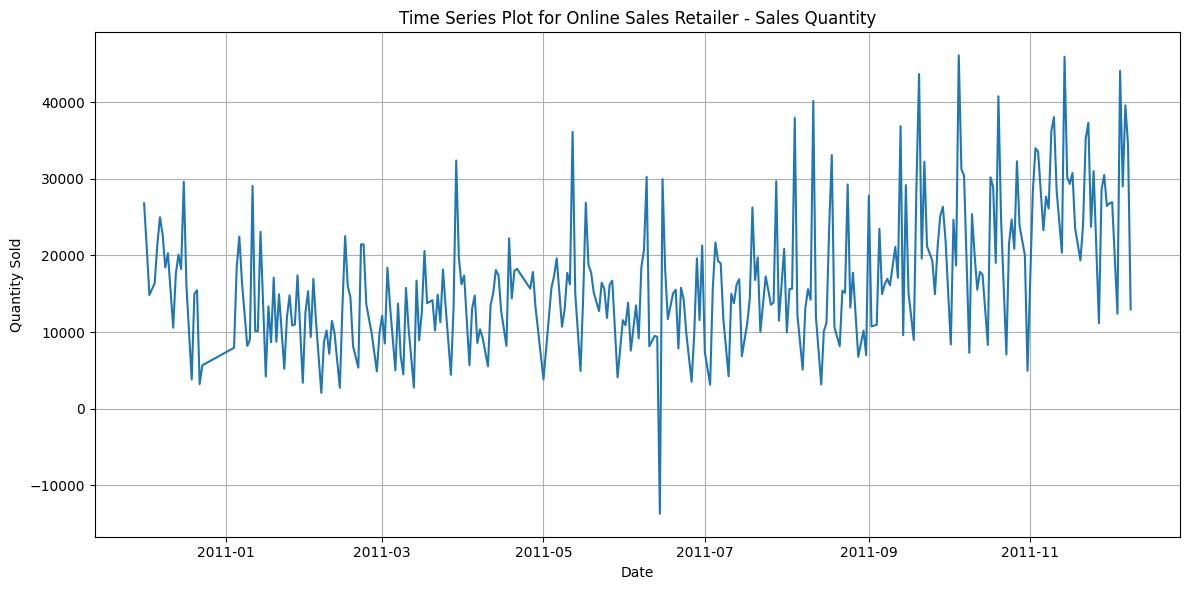

In [204]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(salesquantity_by_date['FullDate'], salesquantity_by_date['Quantity'])
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title(f'Time Series Plot for Online Sales Retailer - Sales Quantity')
plt.grid(True)
plt.tight_layout()
plt.show()

In [205]:
decomposition_quantity = seasonal_decompose(salesquantity_by_date['Quantity'], model='additive', period=30)  # Adjust period if needed

# Access the components
trend_quantity = decomposition_quantity.trend
seasonal_quantity = decomposition_quantity.seasonal
residual_quantity = decomposition_quantity.resid


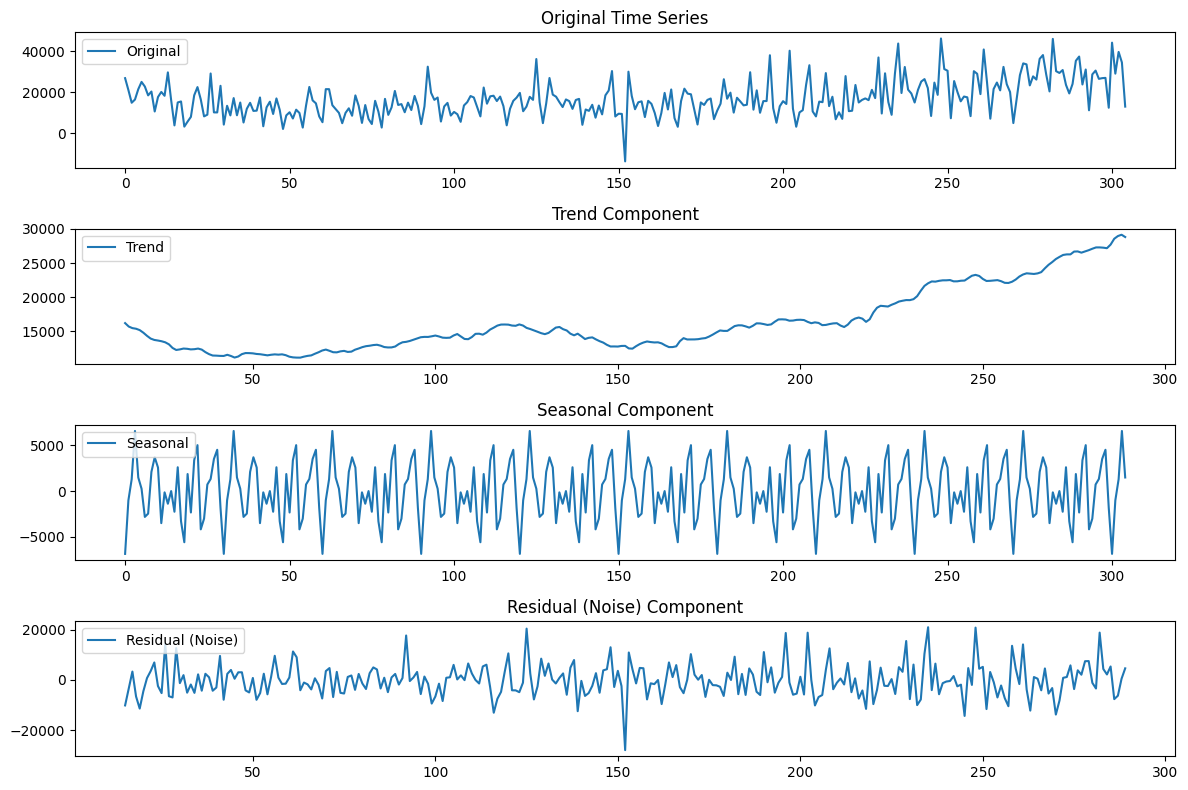

In [206]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(salesquantity_by_date['Quantity'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend_quantity, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal_quantity, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual_quantity, label='Residual (Noise)')
plt.legend(loc='upper left')
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

### **ACF Plots for Seasonality of Sales Quantity**

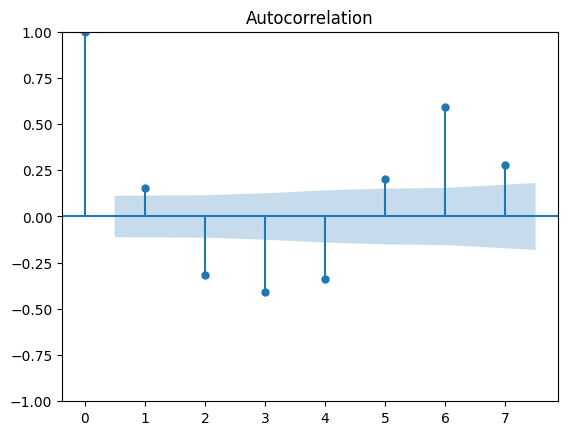

In [207]:
plot_acf(seasonal_quantity, lags=7)  # Adjust lags as needed
plt.show()

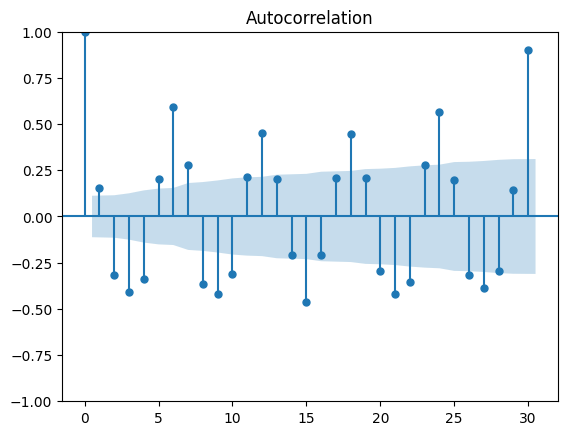

In [208]:
  plot_acf(seasonal_quantity, lags=30)  # Adjust lags as needed
  plt.show()

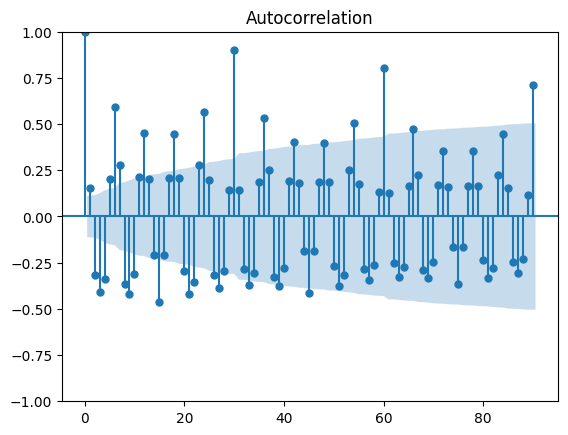

In [209]:
plot_acf(seasonal_quantity, lags=90)  # Adjust lags as needed
plt.show()

## **Time series profiling of sales dollars versus date**

**Key findings**


*   Overall trend of sales dollars has a positive trajectory over time - especially over the last 100 days
*   Sales dollars has seasonality, there is strong seasonality every 30 days, some seasonality every 90 days (weakens after 30 days), and weak to no seasonality on a weekly basis


**Approach**

*   Grouped the data by sales dollars and date (full date)
*   Visualized the variation of sales dollars with date
*   Decomposed time series data to extract trend, seasonality and noise
*   To interpret seasonality, generated ACF plots with 7, 30 and 90 day lages

In [210]:
salesdollars_by_date = online_retail_data.groupby(['FullDate'])['SalesDollars'].sum().reset_index()

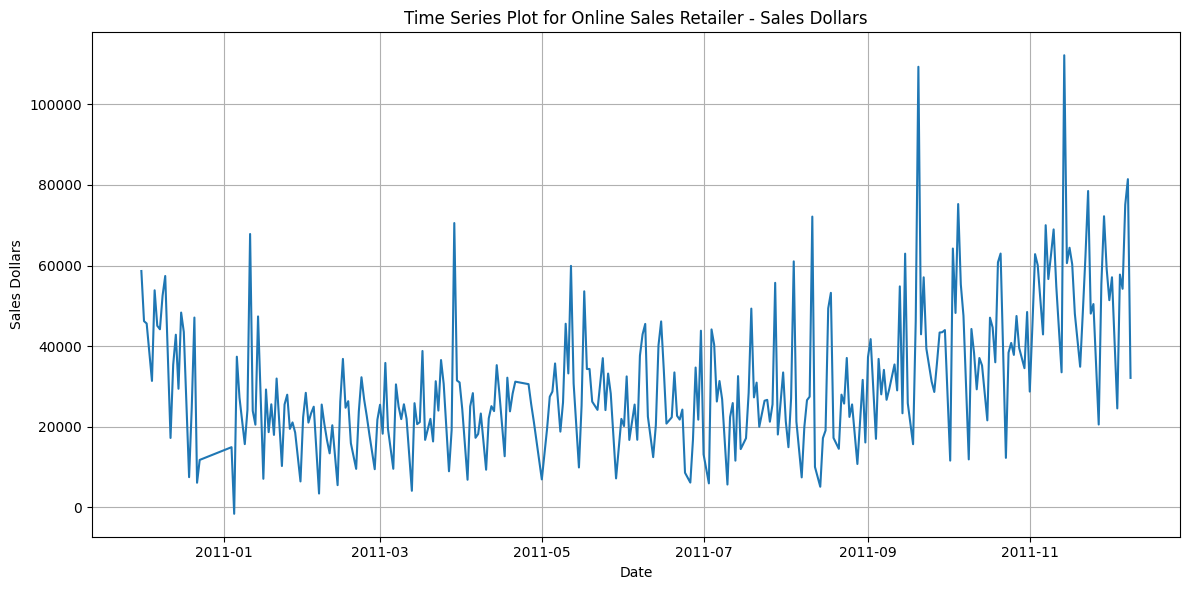

In [211]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(salesdollars_by_date['FullDate'], salesdollars_by_date['SalesDollars'])
plt.xlabel('Date')
plt.ylabel('Sales Dollars')
plt.title(f'Time Series Plot for Online Sales Retailer - Sales Dollars')
plt.grid(True)
plt.tight_layout()
plt.show()

In [212]:
# Decompose the time series
decomposition_sales = seasonal_decompose(salesdollars_by_date['SalesDollars'], model='additive', period=30)  # Adjust period if needed

# Access the components
trend_sales = decomposition_sales.trend
seasonal_sales = decomposition_sales.seasonal
residual_sales = decomposition_sales.resid


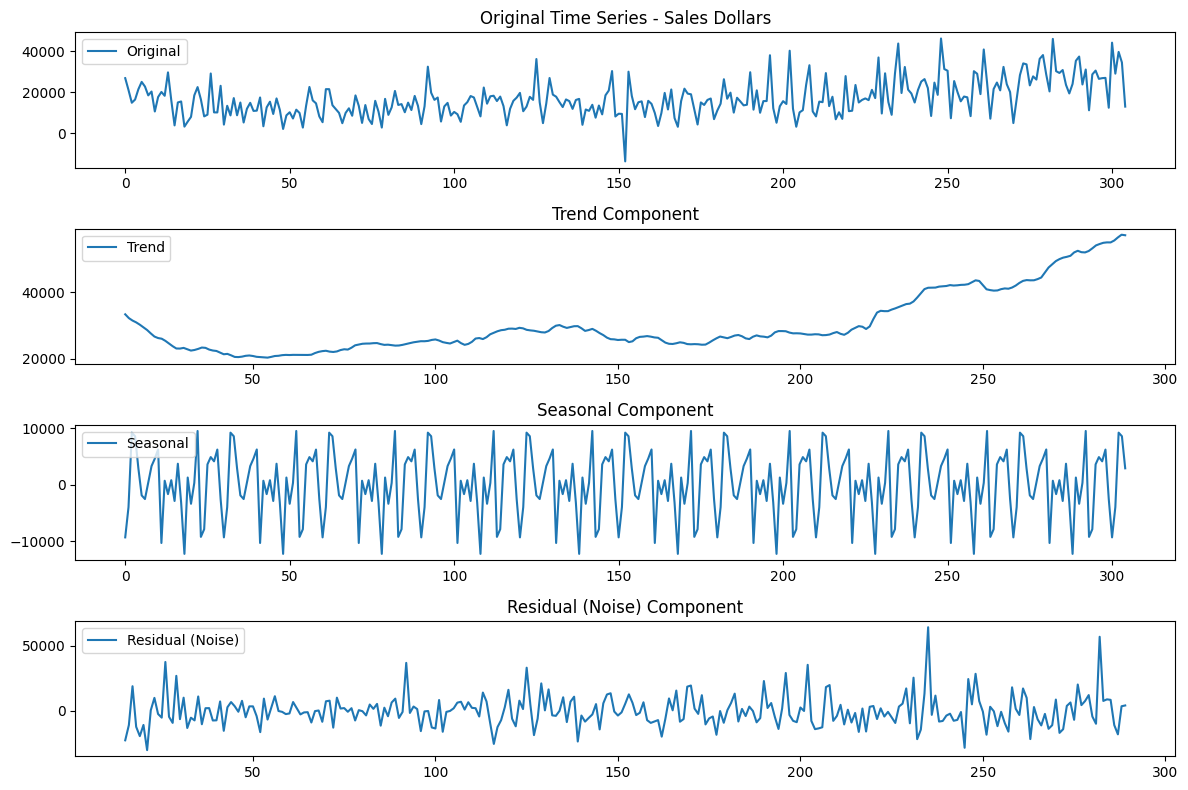

In [213]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(salesquantity_by_date['Quantity'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series - Sales Dollars')

plt.subplot(412)
plt.plot(trend_sales, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal_sales, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual_sales, label='Residual (Noise)')
plt.legend(loc='upper left')
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

### **ACF Plots for Seasonality of Sales Dollars**

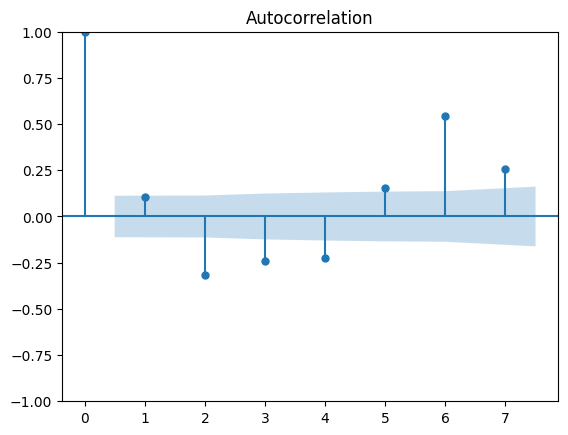

In [214]:
plot_acf(seasonal_sales, lags=7)  # Adjust lags as needed
plt.show()

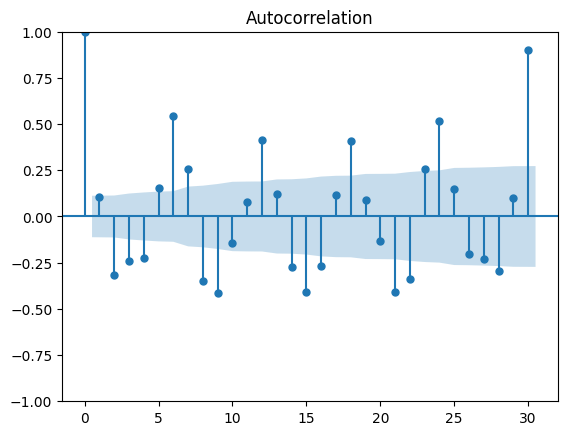

In [215]:
plot_acf(seasonal_sales, lags=30)  # Adjust lags as needed
plt.show()

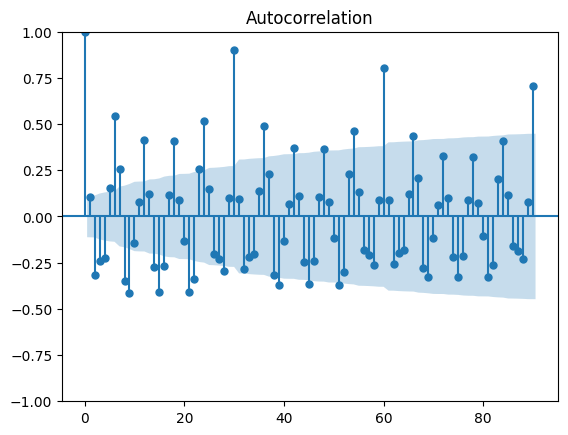

In [216]:
plot_acf(seasonal_sales, lags=90)  # Adjust lags as needed
plt.show()

## **Visualization of other data elements in online sales**


*   Distribution of sales by country - most of sales are in UK
*   Monthly sales - sales are showing are an updward trajectory except in Dec 2012




In [217]:
country_sales = online_retail_data.groupby('Country')['Quantity'].sum().reset_index()
country_sales = country_sales.sort_values(by=['Quantity'], ascending=False)


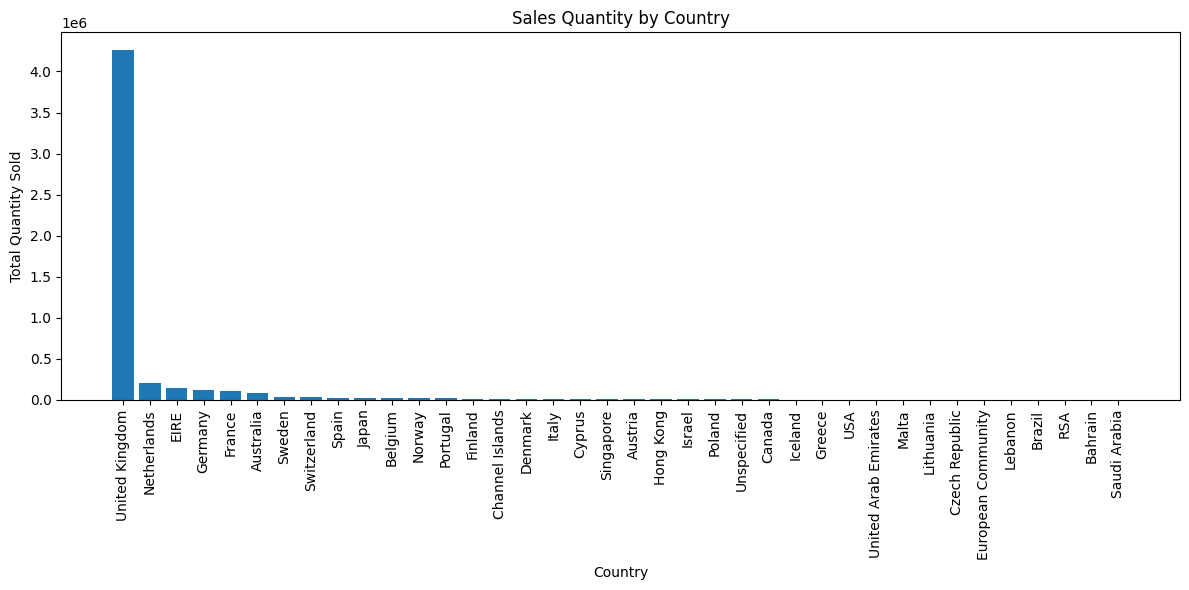

In [218]:
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(country_sales['Country'], country_sales['Quantity'])
plt.xlabel('Country')
plt.ylabel('Total Quantity Sold')
plt.title('Sales Quantity by Country')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [219]:
yearly_sales = online_retail_data.groupby('Year')['Quantity'].sum().reset_index()
yearly_sales = yearly_sales.sort_values(by=['Year'], ascending=True)
yearly_sales

,Year,Quantity
0,2010,342228
1,2011,4834222


In [220]:
year_month_sales = online_retail_data.groupby('YearMonth')['Quantity'].sum().reset_index()
year_month_sales = year_month_sales.sort_values(by=['YearMonth'], ascending=True)

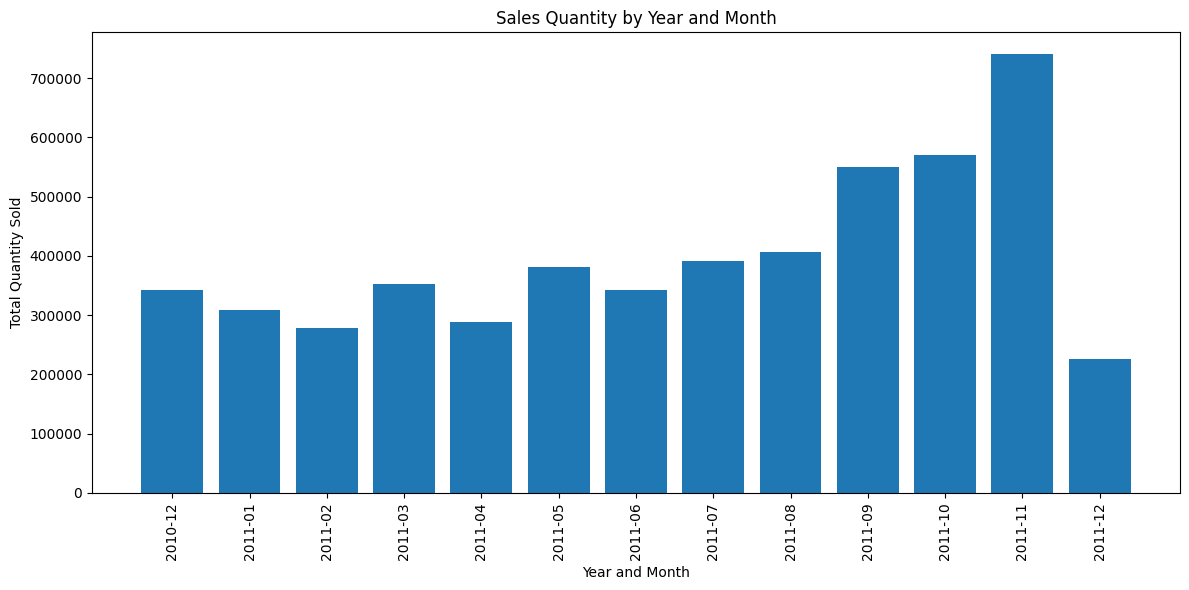

In [221]:
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(year_month_sales ['YearMonth'], year_month_sales ['Quantity'])
plt.xlabel('Year and Month')
plt.ylabel('Total Quantity Sold')
plt.title('Sales Quantity by Year and Month')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [222]:
# RNN Forecasting model for SalesDollars

## **RNN Model Forecasting for Sales Dollars**




### **Creating RNN Model with standard parameters**


*   Create a dataframe Daily Sales that calculates sales dollars by date
*   Used MinMax Scaler to scale the data
*   Created lagged features - using a look back period of 7 days


*   Split the data into training and test set
*   Used a sequential model using the Keras library, specifically designed for time series forecasting or sequence prediction tasks using Long Short-Term Memory (LSTM) networks.


*   The first layer of the model has 32 units (memory cells)
*   The first layer outputs the full sequence of hidden states to the next LSTM layer


*   The model has a second layer of 32 units
*   The model has a dense layer as the output with a single neuron - output is a single value - next sales quantity


*   The model is trained with the training set data with batch size of 32 - weights would be updated after processing 32 samples
*   











In [223]:
daily_sales = online_retail_data.groupby('FullDate')['SalesDollars'].sum().reset_index()
daily_sales = daily_sales.set_index('FullDate') # Set 'FullDate' as index

In [224]:
# Assuming daily_sales is your DataFrame with 'FullDate' as index and 'SalesDollars' as the column
data = daily_sales['SalesDollars'].values.reshape(-1, 1)  # Reshape for scaling


In [225]:
# Scale the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [226]:
# Create lagged features (e.g., using previous 7 days' sales)
look_back = 7  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(data)):
    X.append(data[i - look_back:i, 0])
    y.append(data[i, 0])

X, y = np.array(X), np.array(y)

In [227]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series

In [228]:
# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [229]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
model.add(LSTM(units=32))  # You can add more LSTM layers
model.add(Dense(1))

In [230]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [231]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)  # Adjust epochs and batch size

### **Predictions of Sales Dollars using RNN Model**


*   After training the model, predict sales dollars using predict function
*   Inverse transform the test data and the prediction values to get actual sales dollars in test and predicted data set


*   Plot the results
*   Calculate the RMSE using the test and predicted values





In [232]:
predictions = model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])  # Reshape y_test for inverse transform

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


In [233]:
# Assuming 'daily_sales' has a 'FullDate' index
test_dates = daily_sales.index[-len(y_test[0]):]  # Get dates for the test set


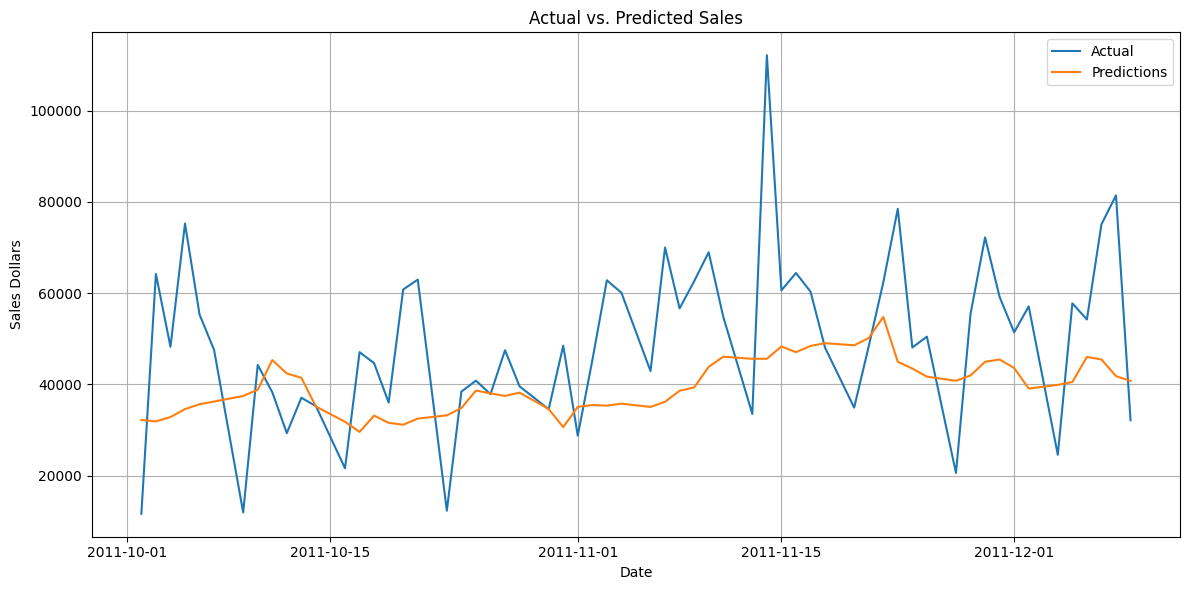

In [234]:
# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Dollars')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [235]:
rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE: {rmse}')

RMSE: 19988.282474087828


### **Hyperparmater tuning to find optimal RNN Model for Sales Dollar forecasting**


*   Used the following hyperparmeters to find the optimal model with lowest RMSE

    *   Look back period - 7, 30, 90 days
    *   Number of units in model - 32,64,128,258
    *   Batch sizes - 16,32,64


*   Used nested for loops to  different models with different hyper parameters
*   After training each model, generated predictions based on test data


*   For each model calcualted the RMSE using prediction and test data
*   Captured the parameters for the model with the lowest RMSE as the "optimal model"








In [236]:
# Define a range of hyperparameters to search
units = [32, 64, 128, 256]
look_backs = [7, 30, 90]
batch_sizes = [16, 32, 64]

best_rmse = float('inf')
best_params = {}

In [237]:
# Loop through hyperparameter combinations
for look_back in look_backs:
  X, y = [], []
  for i in range(look_back, len(data)):
    X.append(data[i - look_back:i, 0])
    y.append(data[i, 0])
  X, y = np.array(X), np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  y_test = scaler.inverse_transform([y_test])
  y_test = y_test.reshape(-1, 1)
  for unit in units:
    for batch_size in batch_sizes:
      model = Sequential()
      model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
      model.add(LSTM(units=unit))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error', optimizer='adam')
      early_stopping = EarlyStopping(monitor='val_loss', patience=10)
      y_train = y_train.reshape(-1, 1)
      model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)
      predictions = model.predict(X_test)

      predictions = scaler.inverse_transform(predictions)
      rmse = np.sqrt(mean_squared_error(y_test, predictions))
      if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'units': unit, 'look_back': look_back, 'batch_size': batch_size}
        print(f'New best RMSE: {best_rmse} with params: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best Parameters: {best_params}')




2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
New best RMSE: 23381.75449606452 with params: {'units': 32, 'look_back': 7, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step
New best RMSE: 23360.453439953126 with params: {'units': 32, 'look_back': 7, 'batch_size': 32}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
New best RMSE: 21897.565323483323 with params: {'units': 32, 'look_back': 7, 'batch_size': 64}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step
New best RMSE: 20788.443022767133 with params: {'units': 64, 'look_back': 7, 'batch_size': 64}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/st

### **Optimal RNN Model for Sales Dollar Forecasting**


*   Using the optimal hyper parameters trained the model - 30 day look back, 128 units, batch size of 64
*   Generated predictions and calculate RMSE


*   Plotted the test data and predicted sales dollar





In [238]:
#Optimal Model RNN Model
optimal_look_back = best_params['look_back']
optimal_units = best_params['units']
optimal_batch_size = best_params['batch_size']
print("The optimal RNN Model for Sales Forecase")
print(f'Optimal look_back: {optimal_look_back}')
print(f'Optimal units: {optimal_units}')
print(f'Optimal batch_size: {optimal_batch_size}')

The optimal RNN Model for Sales Forecase
Optimal look_back: 30
Optimal units: 128
Optimal batch_size: 64


In [239]:
look_back = optimal_look_back  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(data)):
    X.append(data[i - look_back:i, 0])
    y.append(data[i, 0])

X, y = np.array(X), np.array(y)

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series

In [241]:
# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [242]:
optimal_model = Sequential()
optimal_model.add(LSTM(units=optimal_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
optimal_model.add(LSTM(units=optimal_units))  # You can add more LSTM layers
optimal_model.add(Dense(1))

In [243]:
optimal_model.compile(loss='mean_squared_error', optimizer='adam')

In [244]:
optimal_model.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size, verbose=0)  # Adjust epochs and batch size

In [245]:
predictions = optimal_model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


In [246]:
optimal_rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE for optimal RNN model is  {optimal_rmse}')

RMSE for optimal RNN model is  17935.845616402723


In [247]:
test_dates = daily_sales.index[-len(y_test[0]):]

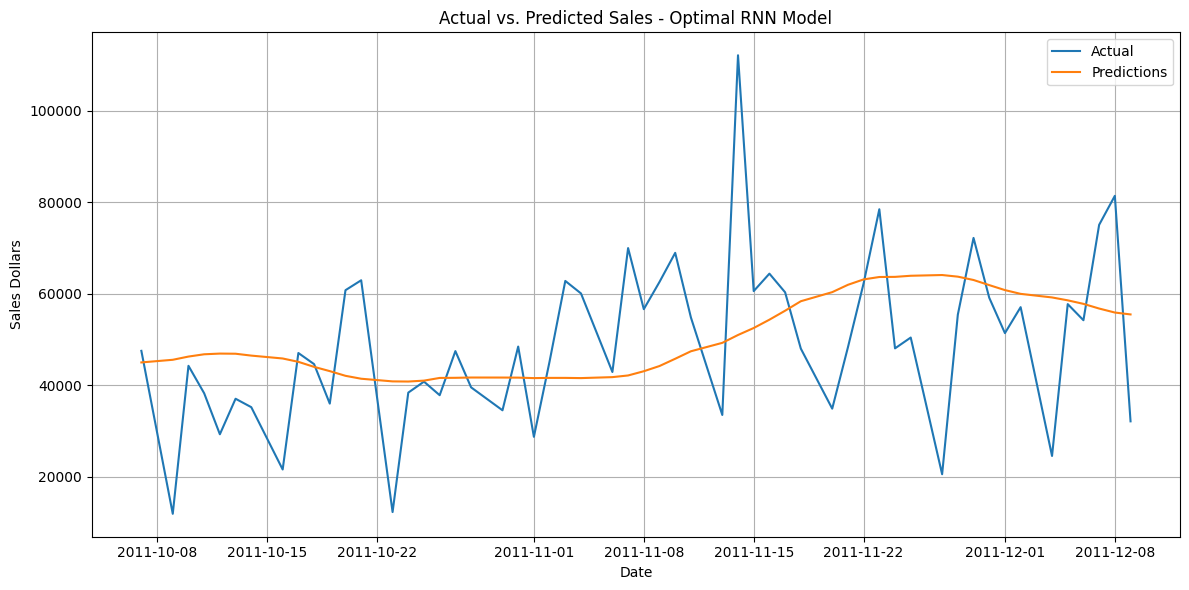

In [248]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Dollars')
plt.title('Actual vs. Predicted Sales - Optimal RNN Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **RNN Model Forecasting for Sales Quantity**

### **Creating RNN Model with standard parameters for sales quantity forecasting**


*   Create a dataframe Daily sales quantity that calculates quantity by date
*   Used MinMax Scaler to scale the data
*   Created lagged features - using a look back period of 7 days


*   Split the data into training and test set
*   Used a sequential model using the Keras library, specifically designed for time series forecasting or sequence prediction tasks using Long Short-Term Memory (LSTM) networks.


*   The first layer of the model has 32 units (memory cells)
*   The first layer outputs the full sequence of hidden states to the next LSTM layer


*   The model has a second layer of 32 units
*   The model has a dense layer as the output with a single neuron - output is a single value - next sales quantity


*   The model is trained with the training set data with batch size of 32 - weights would be updated after processing 32 samples


In [249]:
daily_quantity = online_retail_data.groupby('FullDate')['Quantity'].sum().reset_index()
daily_quantity = daily_quantity.set_index('FullDate') # Set 'FullDate' as index

In [250]:
quantity_data = daily_sales['SalesDollars'].values.reshape(-1, 1)  # Reshape for scaling


In [251]:
scaler = MinMaxScaler()

quantity_data = scaler.fit_transform(quantity_data)


In [252]:
# Create lagged features (e.g., using previous 7 days' sales)
look_back = 7  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(quantity_data)):
    X.append(quantity_data[i - look_back:i, 0])
    y.append(quantity_data[i, 0])

X, y = np.array(X), np.array(y)


In [253]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [254]:
quant_model = Sequential()
quant_model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
quant_model.add(LSTM(units=32))  # You can add more LSTM layers
quant_model.add(Dense(1))

quant_model.compile(loss='mean_squared_error', optimizer='adam')

In [255]:
quant_model.fit(X_train, y_train, epochs=100, batch_size=32,verbose=0)  # Adjust epochs and batch size


In [256]:
predictions = quant_model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])  # Reshape y_test for inverse transform

rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE: for quantity forecasting {rmse}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
RMSE: for quantity forecasting 20022.56296534737


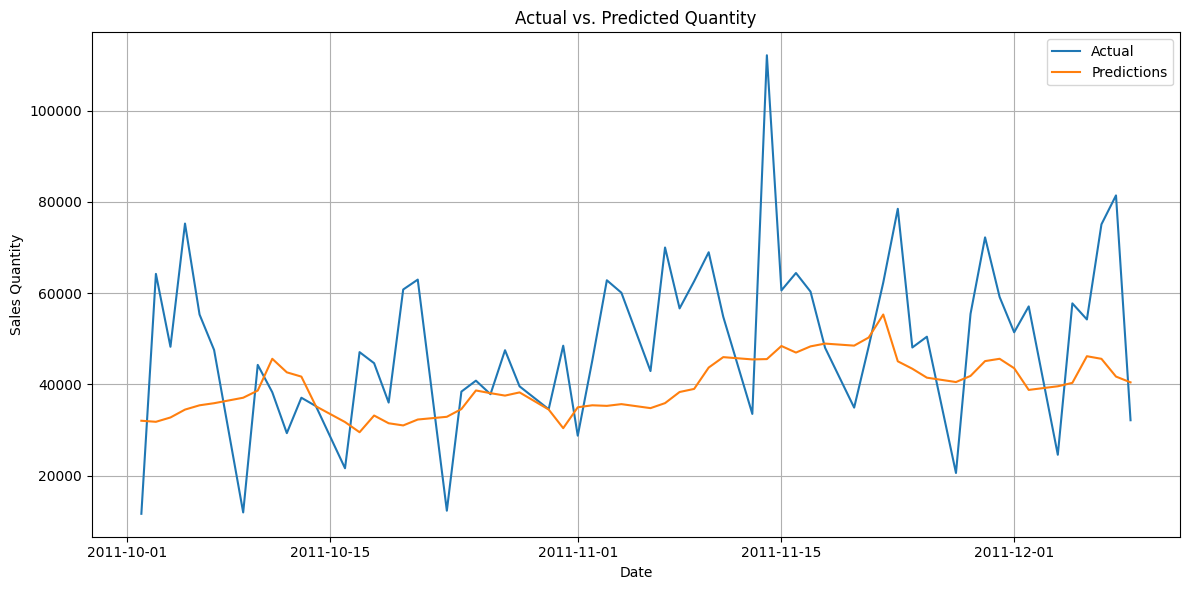

In [257]:
test_dates = daily_quantity.index[-len(y_test[0]):]  # Get dates for the test set

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.title('Actual vs. Predicted Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Hyperparmater tuning to find optimal RNN Model for forecasting sales quantity**


*   Used the following hyperparmeters to find the optimal model with lowest RMSE

    *   Look back period - 7, 30, 90 days
    *   Number of units in model - 32,64,128,258
    *   Batch sizes - 16,32,64


*   Used nested for loops to  different models with different hyper parameters
*   After training each model, generated predictions based on test data


*   For each model calcualted the RMSE using prediction and test data
*   Captured the parameters for the model with the lowest RMSE as the "optimal model"


In [258]:
# Define a range of hyperparameters to search
units = [32, 64, 128, 256]
look_backs = [7, 30, 90]
batch_sizes = [16, 32, 64]

best_rmse_quants = float('inf')
best_params_quants = {}

In [259]:
for look_back in look_backs:
  X, y = [], []
  for i in range(look_back, len(quantity_data)):
    X.append(quantity_data[i - look_back:i, 0])
    y.append(quantity_data[i, 0])
  X, y = np.array(X), np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  y_test = scaler.inverse_transform([y_test])
  y_test = y_test.reshape(-1, 1)
  for unit in units:
    for batch_size in batch_sizes:
      model = Sequential()
      model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
      model.add(LSTM(units=unit))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error', optimizer='adam')
      early_stopping = EarlyStopping(monitor='val_loss', patience=10)
      y_train = y_train.reshape(-1, 1)
      model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)
      predictions = model.predict(X_test)

      predictions = scaler.inverse_transform(predictions)
      rmse = np.sqrt(mean_squared_error(y_test, predictions))
      if rmse < best_rmse_quants:
        best_rmse_quants = rmse
        best_params_quants = {'units': unit, 'look_back': look_back, 'batch_size': batch_size}
        print(f'New best RMSE: {best_rmse_quants} with params: {best_params_quants}')
print("The model with best RMSE")
print(f'Best RMSE: {best_rmse_quants}')
print(f'Best Parameters: {best_params_quants}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
New best RMSE: 22950.836165067012 with params: {'units': 32, 'look_back': 7, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
New best RMSE: 22435.687724342613 with params: {'units': 64, 'look_back': 7, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
New best RMSE: 20998.28843786871 with params: {'units': 64, 'look_back': 7, 'batch_size': 64}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
New best RMSE: 20345.758920934728 with params: {'units': 32, 'look_back': 30, 'batch_size': 64}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/s

### **Optimal RNN Model for Sales Quantity Forecasting**


*   Using the optimal hyper parameters trained the model - 30 day look back, 32 units, batch size of 64 (Please note these may change)
*   Generated predictions and calculate RMSE


*   Plotted the test data and predicted sales dollar

In [260]:
#Optimal Model RNN Model for Quantity Forecast
optimal_look_back_quants = best_params_quants['look_back']
optimal_units_quants = best_params_quants['units']
optimal_batch_size_quants = best_params_quants['batch_size']
print("The optimal RNN Model for Sales Quantity Forecast")
print(f'Optimal look_back: {optimal_look_back_quants}')
print(f'Optimal units: {optimal_units_quants}')
print(f'Optimal batch_size: {optimal_batch_size_quants}')

The optimal RNN Model for Sales Quantity Forecast
Optimal look_back: 30
Optimal units: 32
Optimal batch_size: 64


In [261]:
look_back = optimal_look_back_quants  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(quantity_data)):
    X.append(quantity_data[i - look_back:i, 0])
    y.append(quantity_data[i, 0])

X, y = np.array(X), np.array(y)


In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series

In [263]:
optimal_model_quants = Sequential()
optimal_model_quants.add(LSTM(units=optimal_units_quants, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
optimal_model_quants.add(LSTM(units=optimal_units_quants))  # You can add more LSTM layers
optimal_model_quants.add(Dense(1))


In [264]:
optimal_model_quants.compile(loss='mean_squared_error', optimizer='adam')

optimal_model_quants.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size_quants, verbose=0)  # Adjust epochs and batch size


In [265]:
predictions = optimal_model_quants.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

optimal_rmse_quants = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE for optimal RNN model for quantity forecast is  {optimal_rmse_quants}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
RMSE for optimal RNN model for quantity forecast is  17998.345956917812


In [266]:
test_dates = daily_quantity.index[-len(y_test[0]):]

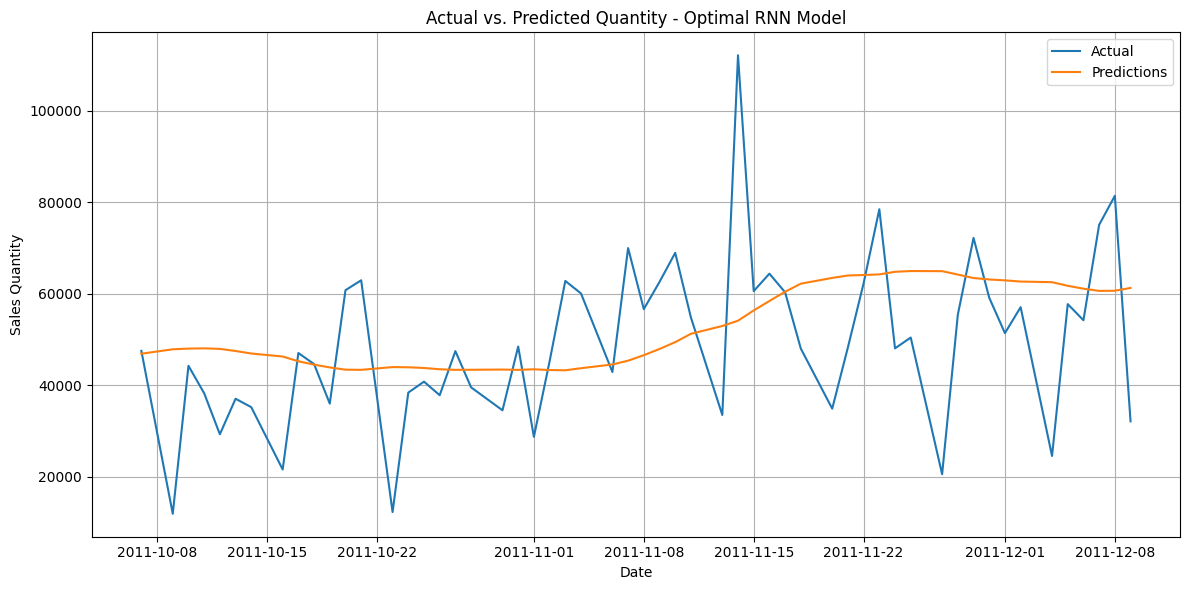

In [267]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.title('Actual vs. Predicted Quantity - Optimal RNN Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()